# Interest-rate curves #
## 7. Euribor curve bootstrapping ##

In [1]:
import math
import numpy
import datetime
import matplotlib.pyplot as plot

In [2]:
import QuantLib as ql

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

### Discounting curve ###

In [4]:
eonia = ql.Eonia()

In [5]:
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                ql.Period(1, ql.Days), fixingDays,
                                ql.TARGET(), ql.Following, False, ql.Actual360())
           for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]]

In [6]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor),
                             ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, tenor in [(0.070, (1, ql.Weeks)), (0.069, (2, ql.Weeks)),
                                (0.078, (3, ql.Weeks)), (0.074, (1, ql.Months))]]

In [7]:
helpers += [ql.DatedOISRateHelper(start_date, end_date,
                                  ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, start_date, end_date in [
                (0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
                (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
                (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
                (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
                (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013))]]

In [8]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor),
            ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia)
            for rate, tenor in [(0.002, (15, ql.Months)), (0.008, (18, ql.Months)),
                                (0.021, (21, ql.Months)), (0.036, (2, ql.Years)),
                                (0.127, (3, ql.Years)), (0.274, (4, ql.Years)),
                                (0.456, (5, ql.Years)), (0.647, (6, ql.Years)),
                                (0.827, (7, ql.Years)), (0.996, (8, ql.Years)),
                                (1.147, (9, ql.Years)), (1.280, (10, ql.Years)),
                                (1.404, (11, ql.Years)), (1.516, (12, ql.Years)),
                                (1.764, (15, ql.Years)), (1.939, (20, ql.Years)),
                                (2.003, (25, ql.Years)), (2.038, (30, ql.Years))]]

In [9]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J * 2.0 / 360))) for J in [0.00102, 0.00086]]
jump_dates = [ql.Date(31, ql.December, 2012), ql.Date(31, ql.December, 2013)]

In [10]:
eonia_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()

### 6-months Euribor ###

In [11]:
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.312 / 100)), 
                                ql.Period(6, ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360()) ]

In [12]:
euribor6m = ql.Euribor6M()

In [13]:
helpers += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                             start, euribor6m)
            for rate, start in [(0.293, 1), (0.272, 2), (0.260, 3),
                                (0.256, 4), (0.252, 5), (0.248, 6),
                                (0.254, 7), (0.261, 8), (0.267, 9),
                                (0.279, 10), (0.291, 11), (0.303, 12),
                                (0.318, 13), (0.335, 14), (0.352, 15),
                                (0.371, 16), (0.389, 17), (0.409, 18)]]

In [14]:
discount_curve = ql.RelinkableYieldTermStructureHandle()
discount_curve.linkTo(eonia_curve)

In [15]:
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                              ql.Period(tenor, ql.Years), ql.TARGET(),
                              ql.Annual, ql.Unadjusted,
                              ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                              discount_curve)
            for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5),
                                (0.954, 6), (1.135, 7), (1.303, 8),
                                (1.452, 9), (1.584, 10), (1.809, 12),
                                (2.037, 15), (2.187, 20), (2.234, 25),
                                (2.256, 30), (2.295, 35), (2.348, 40),
                                (2.421, 50), (2.463, 60)] ]

In [16]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

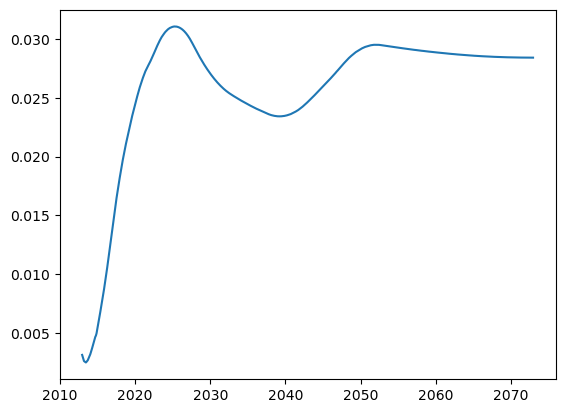

In [17]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate() for d in dates ]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

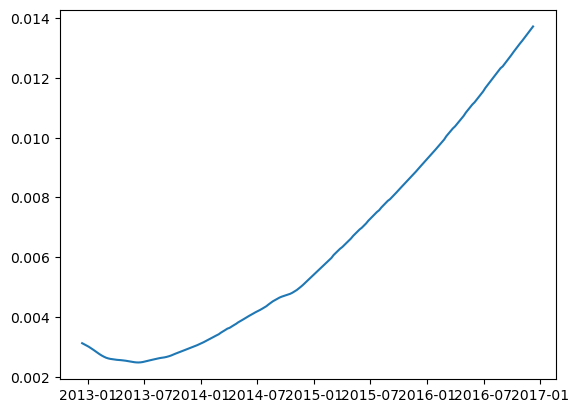

In [18]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), 
                                     ql.Actual360(), ql.Simple).rate() for d in dates ]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

### Synthetic deposits ###

In [20]:
euribor6m_curve_0 = euribor6m_curve

In [21]:
d = ql.TARGET().advance(spot, 1, ql.Days)
F_x = euribor6m_curve_0.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months),
                                    ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months), 
                               ql.Actual360(), ql.Simple).rate()
day_counter = euribor6m.dayCounter()
T_x = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))
alpha = (F_x - F_on)
print(alpha)

0.002949286970370156


In [24]:
synth_helpers = []
for n, units in [(1, ql.Days), (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks),
                 (1, ql.Months), (2, ql.Months), (3, ql.Months),
                 (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, ql.TARGET().advance(spot, n, units),
                                   ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha
    print(ql.Period(n,units), f'{F * 100:.4f}%')
    synth_helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)),
                                              ql.Period(n, units), 2, ql.TARGET(), 
                                              ql.Following, False, ql.Actual360()))

1D 0.3349%
1W 0.3649%
2W 0.3639%
3W 0.3729%
1M 0.3689%
2M 0.3559%
3M 0.3419%
4M 0.3272%
5M 0.3188%


In [25]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers + synth_helpers,
                                               ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

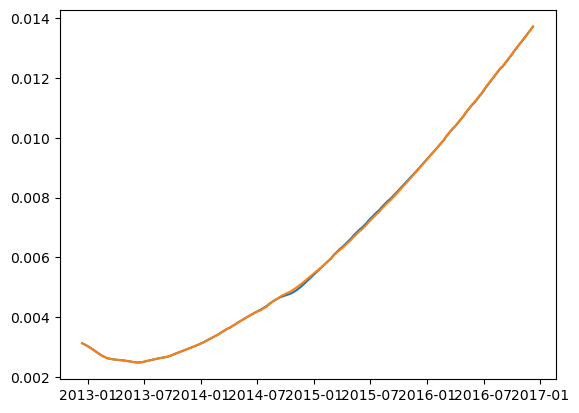

In [26]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                         ql.Actual360(), ql.Simple).rate()
           for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

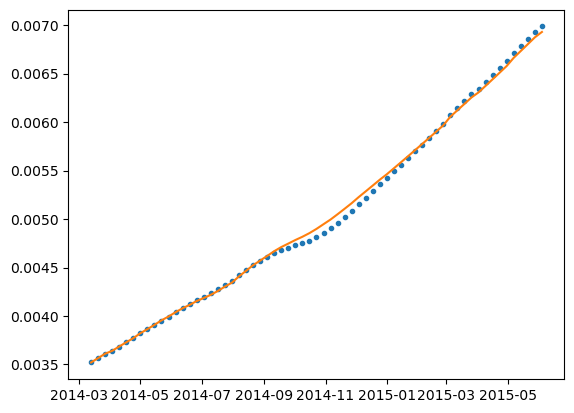

In [27]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(65, 130)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                         ql.Actual360(), ql.Simple).rate()
           for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '.');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

In [28]:
start = ql.TARGET().advance(spot, 1, ql.Days)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
T_x0 = day_counter.yearFraction(start, end)
Delta0 = F_x - F_on
start = ql.TARGET().advance(spot, 1, ql.Months)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
T_x1 = day_counter.yearFraction(start, end)
Delta1 = F_x - F_on
t1 = day_counter.yearFraction(spot, start)
t2 = day_counter.yearFraction(spot, end)
L = numpy.array([[T_x0, 0.5 * T_x0 ** 2], [T_x1, 0.5 * (t2 ** 2 - t1 ** 2)]])
b = numpy.array([Delta0 * T_x0, Delta1 * T_x1])
alpha, beta = numpy.linalg.solve(L,b)
print(alpha, beta)

0.0030464085692271255 -0.0003842173141594401


In [29]:
synth_helpers = []
for n, units in [(1, ql.Days), (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks),
                 (1, ql.Months), (2, ql.Months), (3, ql.Months),
                 (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, ql.TARGET().advance(spot, n, units),
                                   ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha + 0.5 * beta * t
    print(ql.Period(n,units), f'{F * 100:.4f}%')
    synth_helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)),
                                              ql.Period(n, units), 2, ql.TARGET(), 
                                              ql.Following, False, ql.Actual360()))

1D 0.3446%
1W 0.3743%
2W 0.3729%
3W 0.3815%
1M 0.3769%
2M 0.3623%
3M 0.3468%
4M 0.3304%
5M 0.3204%


In [30]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers + synth_helpers,
                                               ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

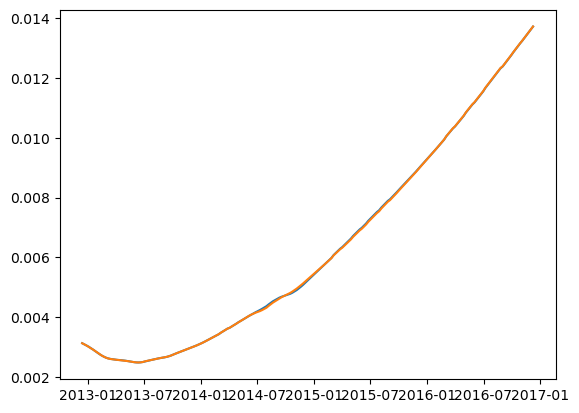

In [31]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 52 * 4 + 1)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                         ql.Actual360(), ql.Simple).rate()
           for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

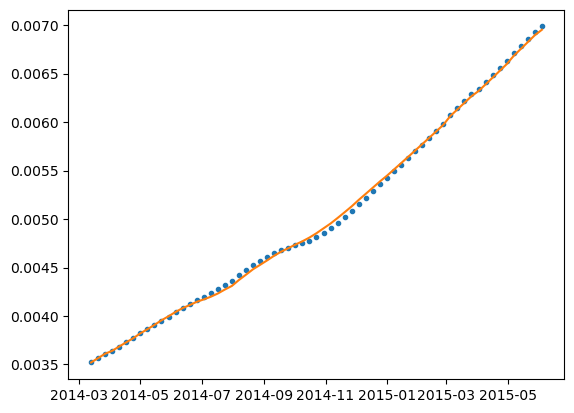

In [32]:
dates = [spot + ql.Period(i, ql.Weeks) for i in range(65, 130)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                         ql.Actual360(), ql.Simple).rate()
           for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '.');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

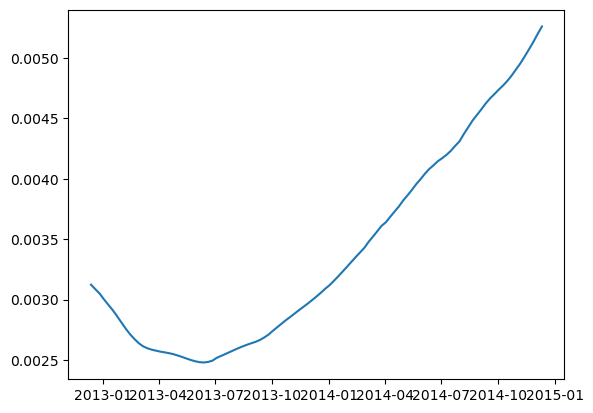

In [33]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate() for d in dates ]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

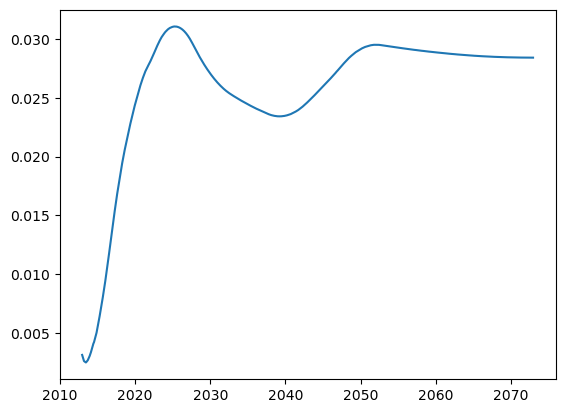

In [34]:
spot = euribor6m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate() for d in dates ]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

### 12.months Euribor ###

In [36]:
euribor12m = ql.Euribor1Y()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.54 / 100)), 
                                ql.Period(12, ql.Months), 2, ql.TARGET(), 
                                ql.Following, False, ql.Actual360())]
helpers += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.5070 / 100)), 12, euribor12m)]

In [38]:
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate + basis) / 100)),
                              ql.Period(tenor, ql.Years), ql.TARGET(),
                              ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                              discount_curve)
            for rate, basis, tenor in [(0.424, 0.179, 3), (0.576, 0.164, 4),
                                       (0.762, 0.151, 5), (0.954, 0.139, 6),
                                       (1.135, 0.130, 7), (1.303, 0.123, 8),
                                       (1.452, 0.118, 9), (1.584, 0.113, 10),
                                       (1.809, 0.106, 12), (2.037, 0.093, 15),
                                       (2.187, 0.080, 20), (2.234, 0.072, 25),
                                       (2.256, 0.066, 30)]]

In [39]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                      ql.Period(*tenor), 2,
                                      ql.TARGET(), ql.Following, False, ql.Actual360())
                 for rate, tenor in [(0.6537, (1, ql.Months)), (0.6187, (3, ql.Months)),
                                     (0.5772, (6, ql.Months)), (0.5563, (9, ql.Months))]]

In [40]:
synth_helpers += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                   months_to_start, euribor12m)
                  for rate, months_to_start in [(0.4974, 3), (0.4783, 6), (0.4822, 9),
                                                (0.5481, 15), (0.6025, 18)]]

In [41]:
last_basis = 0.066
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate + last_basis) / 100)),
                                    ql.Period(tenor, ql.Years), ql.TARGET(),
                                    ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                                    euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                                    discount_curve)
                  for rate, tenor in [(2.295, 35), (2.348, 40), (2.421, 50), (2.463, 60)]]

In [42]:
euribor12m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                                helpers + synth_helpers,
                                                ql.Actual365Fixed())
euribor12m_curve.enableExtrapolation()

In [43]:
euribor12m_curve_0 = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                                  helpers, ql.Actual365Fixed())
euribor12m_curve_0.enableExtrapolation()

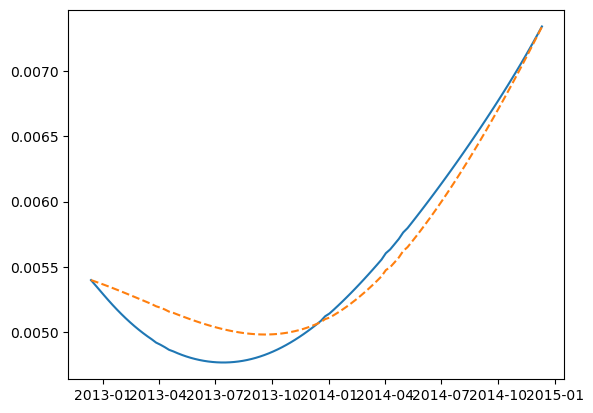

In [44]:
spot = euribor12m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates_0 = [euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate() for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '--');

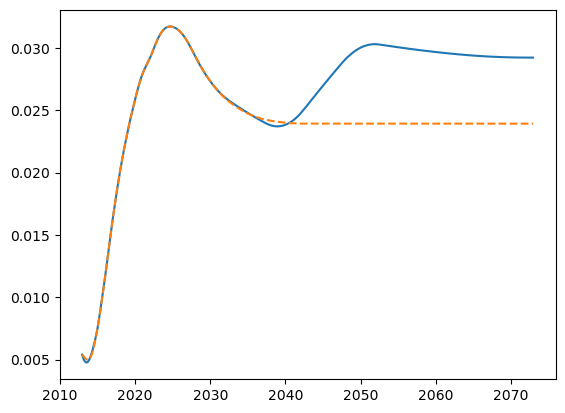

In [45]:
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates_0 = [euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                          ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                      ql.Actual360(), ql.Simple).rate() for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates_0, '--');

### 3-months Euribor ###

In [47]:
euribor3m = ql.Euribor3M()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.179 / 100)),
                                ql.Period(3, ql.Months), 3, ql.TARGET(), 
                                ql.Following, False, ql.Actual360())]
helpers += [ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(100 - rate)),
                                 start_date, euribor3m, ql.QuoteHandle())
            for rate, start_date in [(0.1775, ql.Date(19, ql.December, 2012)),
                                     (0.1274, ql.Date(20, ql.March, 2013)),
                                     (0.1222, ql.Date(19, ql.June, 2013)),
                                     (0.1269, ql.Date(18, ql.September, 2013)),
                                     (0.1565, ql.Date(18, ql.December, 2013)),
                                     (0.1961, ql.Date(19, ql.March, 2014)),
                                     (0.2556, ql.Date(18, ql.June, 2014)),
                                     (0.3101, ql.Date(17, ql.September, 2014))]]

In [48]:
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate - basis) / 100)),
                              ql.Period(tenor, ql.Years), ql.TARGET(),
                              ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve)
            for rate, basis, tenor in [(0.424, 0.1395, 3), (0.576, 0.1390, 4),
                                       (0.762, 0.1395, 5), (0.954, 0.1375, 6),
                                       (1.135, 0.1350, 7), (1.303, 0.1320, 8),
                                       (1.452, 0.1285, 9), (1.584, 0.1250, 10),
                                       (1.809, 0.1170, 12), (2.037, 0.1045, 15),
                                       (2.187, 0.0885, 20), (2.234, 0.0780, 25),
                                       (2.256, 0.0700, 30), (2.348, 0.0600, 40),
                                       (2.421, 0.0540, 50)]]

In [49]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                      ql.Period(*tenor), 2,
                                      ql.TARGET(), ql.Following, False, ql.Actual360())
                 for rate, tenor in [(0.1865, (2, ql.Weeks)), (0.1969, (3, ql.Weeks)),
                                     (0.1951, (1, ql.Months)), (0.1874, (2, ql.Months))]]

In [50]:
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate - basis) / 100)),
                                    ql.Period(tenor, ql.Years), ql.TARGET(),
                                    ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                                    euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days),
                                    discount_curve)
                  for rate, basis, tenor in [(2.295, 0.0650, 35), (2.463, 0.0540, 60)]]

### Turn of year ###

In [51]:
futures = [(0.1775, ql.Date(19, ql.December, 2012)),
           (0.1274, ql.Date(20, ql.March, 2013)),
           (0.1222, ql.Date(19, ql.June, 2013)),
           (0.1269, ql.Date(18, ql.September, 2013)),
           (0.1565, ql.Date(18, ql.December, 2013)),
           (0.1961, ql.Date(19, ql.March, 2014)),
           (0.2556, ql.Date(18, ql.June, 2014)),
           (0.3101, ql.Date(17, ql.September, 2014))]

In [52]:
spot = euribor6m_curve.referenceDate()
day_counter = euribor3m.dayCounter()
quotes, times = zip(*[(q, day_counter.yearFraction(spot, d)) for q, d in futures])
f = ql.MonotonicCubicNaturalSpline(times[:4] + times[5:], quotes[:4] + quotes[5:])

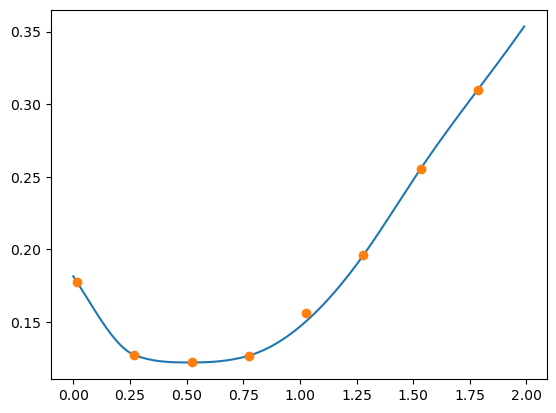

In [53]:
fig, ax = plot.subplots()
ts, fs = zip(*[(t,f(t, True)) for t in numpy.arange(0.0, 2.0, 0.01)])
ax.plot(ts,fs)
_ = ax.plot(times,quotes,'o')

In [56]:
print(f'{quotes[4] * 100:.2f}%', f'{f(times[4]) * 100:.2f}%')

15.65% 15.06%


In [59]:
J = (quotes[4] - f(times[4])) / 100
tau = day_counter.yearFraction(ql.Date(18, ql.December, 2013), ql.Date(18, ql.March, 2014))
print(f'{J * 100:.2f}%', tau)

0.01% 0.25


In [60]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J * tau)))]
jump_dates = [ql.Date(31, ql.December, 2013)]
euribor3m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers + synth_helpers,
                                               ql.Actual365Fixed(),
                                               jumps, jump_dates)
euribor3m_curve.enableExtrapolation()

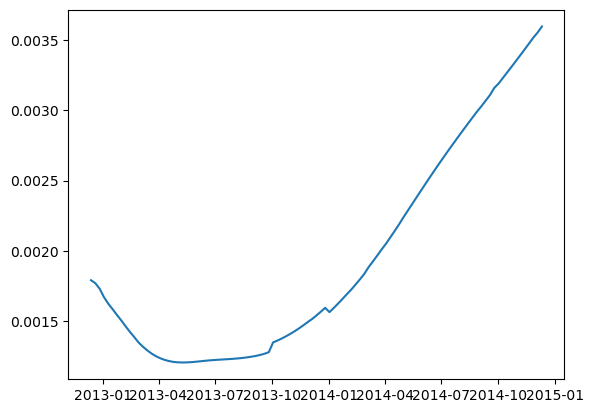

In [61]:
spot = euribor3m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

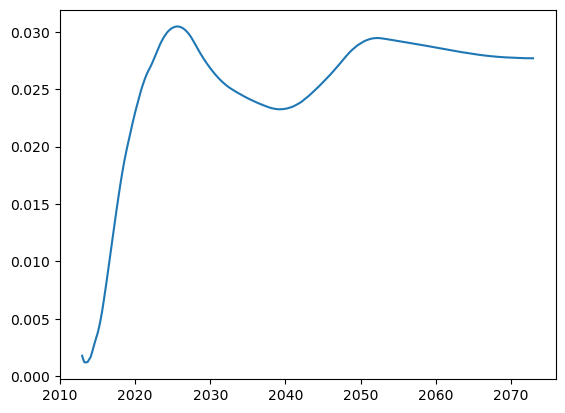

In [62]:
spot = euribor3m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

### 1-month Euribor ###

In [63]:
euribor1m = ql.Euribor1M()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.110 / 100)),
                                ql.Period(1, ql.Months), 2,
                                ql.TARGET(), ql.Following, False, ql.Actual360())]
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                              ql.Period(tenor, ql.Months), ql.TARGET(),
                              ql.Monthly, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve)
            for rate, tenor in [(0.106, 2), (0.096, 3), (0.085, 4), (0.079, 5),
                                (0.075, 6), (0.071, 7), (0.069, 8), (0.066, 9),
                                (0.065, 10), (0.064, 11), (0.063, 12)]]

In [64]:
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate - basis) / 100)),
                              ql.Period(tenor, ql.Years), ql.TARGET(),
                              ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve)
            for rate, basis, tenor in [(0.324, 0.226, 2), (0.424, 0.238, 3),
                                       (0.576, 0.246, 4), (0.762, 0.250, 5),
                                       (0.954, 0.250, 6), (1.135, 0.248, 7),
                                       (1.303, 0.245, 8), (1.452, 0.241, 9),
                                       (1.584, 0.237, 10), (1.703, 0.233, 11),
                                       (1.809, 0.228, 12), (2.037, 0.211, 15),
                                       (2.187, 0.189, 20), (2.234, 0.175, 25),
                                       (2.256, 0.163, 30)]]

In [65]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                      ql.Period(*tenor), 2,
                                      ql.TARGET(), ql.Following, False, ql.Actual360())
                 for rate, tenor in [(0.0661, (1, ql.Days)), (0.098, (1, ql.Weeks)),
                                     (0.0993, (2, ql.Weeks)), (0.1105, (3, ql.Weeks))]]

In [66]:
last_basis = 0.163
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate - last_basis) / 100)),
                                    ql.Period(tenor, ql.Years), ql.TARGET(),
                                    ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                                    euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve)
                  for rate, tenor in [(2.295, 35), (2.348, 40), (2.421, 50), (2.463, 60)]]

In [67]:
J = 0.0016
t_j = euribor1m.dayCounter().yearFraction(ql.Date(31, ql.December, 2012), ql.Date(2, ql.January, 2013))
B = 1.0 / (1.0 + J * t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31, ql.December, 2013)]

In [68]:
euribor1m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(),
                                               helpers + synth_helpers,
                                               ql.Actual365Fixed(),
                                               jumps, jump_dates)
euribor1m_curve.enableExtrapolation()

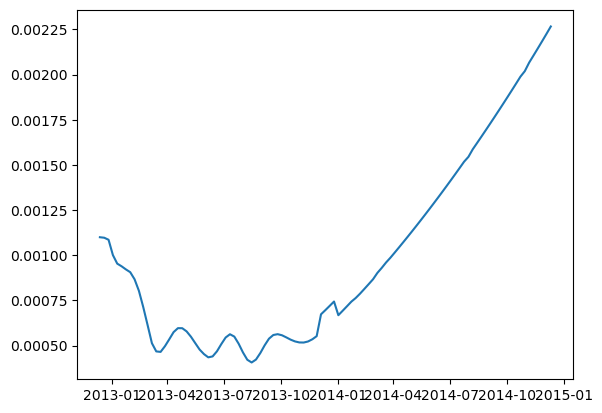

In [69]:
spot = euribor1m_curve.referenceDate()
dates = [spot + ql.Period(i, ql.Weeks) for i in range(0, 2 * 52 + 1)]
rates = [euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

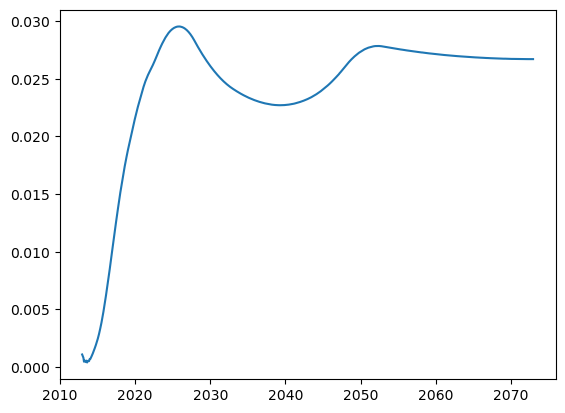

In [70]:
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 60 * 12 + 1)]
rates = [euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d),
                                     ql.Actual360(), ql.Simple).rate()
         for d in dates]
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], rates, '-');

### Basis curves ###

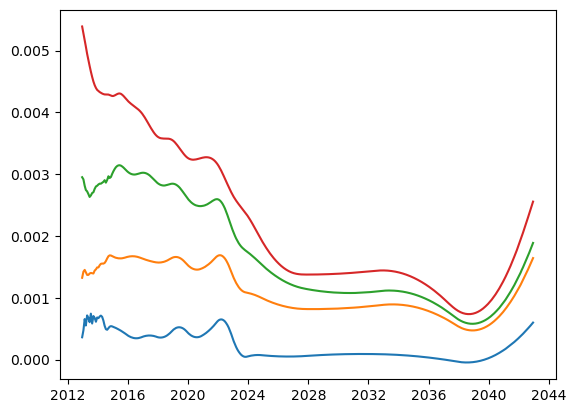

In [71]:
dates = [spot + ql.Period(i, ql.Months) for i in range(0, 12 * 30 + 1)]
def basis(curve, tenor):
    results = []
    for d in dates:
        d2 = ql.TARGET().advance(d, ql.Period(*tenor), ql.ModifiedFollowing)
        FRA1 = curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        FRA2 = eonia_curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        results.append(FRA1 - FRA2)
    return results
basis_1m = basis(euribor1m_curve, (1, ql.Months))
basis_3m = basis(euribor3m_curve, (3, ql.Months))
basis_6m = basis(euribor6m_curve, (6, ql.Months))
basis_12m = basis(euribor12m_curve, (12, ql.Months))
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], basis_1m, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], basis_3m, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], basis_6m, '-');
plot.plot([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in dates], basis_12m, '-');